In [5]:
# install package
!pip install ucimlrepo -q


In [1]:
# 1. Setup & Imports


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [7]:
from ucimlrepo import fetch_ucirepo

# load dataset
heart_disease = fetch_ucirepo(id=45)

# features and target
X_raw = heart_disease.data.features.copy()
y_raw = heart_disease.data.targets.copy()

print("Feature shape:", X_raw.shape)
print("Target shape:", y_raw.shape)
X_raw.head()

Feature shape: (303, 13)
Target shape: (303, 1)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0


In [8]:
# inspect target
y_raw.head()


,num
0,0
1,2
2,1
3,0
4,0


In [9]:
# clean data
df = pd.concat([X_raw, y_raw], axis=1)

# drop missing rows
df = df.dropna()

# target column name
target_col = df.columns[-1]
print("Target column:", target_col)

# binary target
y = (df[target_col] > 0).astype(int)

# final features
X = df.drop(columns=[target_col])

print("Clean features shape:", X.shape)
print("Clean target shape:", y.shape)


Target column: num
Clean features shape: (297, 13)
Clean target shape: (297,)


In [10]:
# split data
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])


Train samples: 237
Test samples: 60


In [11]:
# helper function
def evaluate_model(clf, X_train, y_train, X_test, y_test, label=None):
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    if label is not None:
        print(f"{label:25s} | Train: {train_acc:.4f} | Test: {test_acc:.4f}")

    return train_acc, test_acc


In [12]:
# baseline model
baseline_knn = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=5))
])

base_train_acc, base_test_acc = evaluate_model(
    baseline_knn,
    X_train,
    y_train,
    X_test,
    y_test,
    label="KNN k = 5"
)

print("\nClassification report:")
print(classification_report(y_test, baseline_knn.predict(X_test)))

print("Confusion matrix:")
print(confusion_matrix(y_test, baseline_knn.predict(X_test)))


KNN k = 5                 | Train: 0.8692 | Test: 0.8833

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90        32
           1       0.92      0.82      0.87        28

    accuracy                           0.88        60
   macro avg       0.89      0.88      0.88        60
weighted avg       0.89      0.88      0.88        60

Confusion matrix:
[[30  2]
 [ 5 23]]


In [13]:
# hyperparameter loop
k_values = list(range(1, 26, 2))

train_scores = []
test_scores = []

print("K values summary\n")

for k in k_values:
    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=k))
    ])

    label = f"k = {k}"
    tr_acc, te_acc = evaluate_model(
        clf,
        X_train,
        y_train,
        X_test,
        y_test,
        label=label
    )

    train_scores.append(tr_acc)
    test_scores.append(te_acc)


K values summary

k = 1                     | Train: 1.0000 | Test: 0.7833
k = 3                     | Train: 0.8903 | Test: 0.9000
k = 5                     | Train: 0.8692 | Test: 0.8833
k = 7                     | Train: 0.8565 | Test: 0.8333
k = 9                     | Train: 0.8397 | Test: 0.8667
k = 11                    | Train: 0.8523 | Test: 0.8833
k = 13                    | Train: 0.8523 | Test: 0.8667
k = 15                    | Train: 0.8523 | Test: 0.8500
k = 17                    | Train: 0.8481 | Test: 0.8500
k = 19                    | Train: 0.8608 | Test: 0.8667
k = 21                    | Train: 0.8565 | Test: 0.8500
k = 23                    | Train: 0.8565 | Test: 0.8667
k = 25                    | Train: 0.8439 | Test: 0.8667


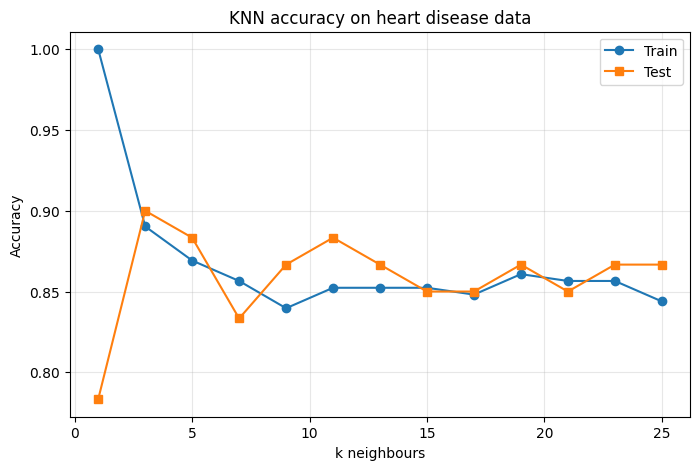

In [14]:
# accuracy plot
plt.figure(figsize=(8, 5))
plt.plot(k_values, train_scores, marker="o", label="Train")
plt.plot(k_values, test_scores, marker="s", label="Test")
plt.xlabel("k neighbours")
plt.ylabel("Accuracy")
plt.title("KNN accuracy on heart disease data")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


In [15]:
# best k
results = pd.DataFrame({
    "k": k_values,
    "train_accuracy": train_scores,
    "test_accuracy": test_scores
})

best_row = results.iloc[results["test_accuracy"].idxmax()]
best_k = int(best_row["k"])
best_acc = best_row["test_accuracy"]

print("Best k:", best_k)
print("Best test accuracy:", round(best_acc, 4))
results


Best k: 3
Best test accuracy: 0.9


,k,train_accuracy,test_accuracy
0,1,1.000000,0.783333
1,3,0.890295,0.900000
2,5,0.869198,0.883333
3,7,0.856540,0.833333
4,9,0.839662,0.866667
5,11,0.852321,0.883333
6,13,0.852321,0.866667
7,15,0.852321,0.850000
8,17,0.848101,0.850000
9,19,0.860759,0.866667


In [16]:
# final model
best_knn = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=best_k))
])

best_knn.fit(X_train, y_train)
y_pred_best = best_knn.predict(X_test)

print(f"Final model k {best_k}\n")
print("Classification report:")
print(classification_report(y_test, y_pred_best))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_best))


Final model k 3

Classification report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        32
           1       0.89      0.89      0.89        28

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60

Confusion matrix:
[[29  3]
 [ 3 25]]


In [17]:
# Drop missing values as used in your modelling pipeline
df_clean = df.dropna()
y_clean = (df_clean[target_col] > 0).astype(int)

print("=== Cleaned Dataset Shape ===")
print(df_clean.shape)
print()

print("=== Cleaned Target Distribution ===")
display(y_clean.value_counts(normalize=True).rename("proportion"))


=== Cleaned Dataset Shape ===
(297, 14)

=== Cleaned Target Distribution ===


,proportion
num,
0,0.538721
1,0.461279


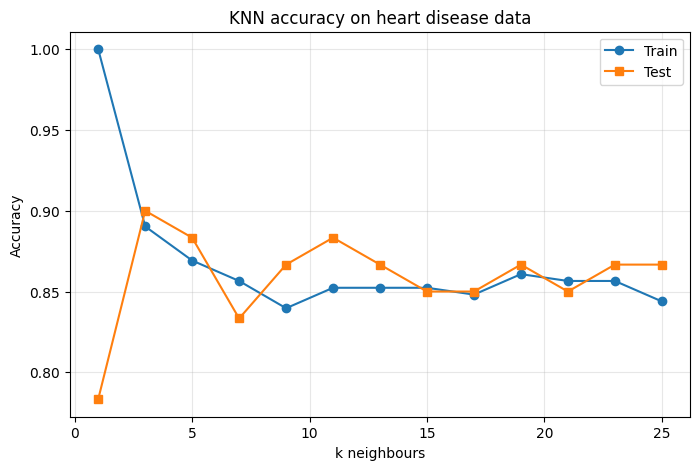

In [18]:
plt.figure(figsize=(8, 5))
plt.plot(k_values, train_scores, marker="o", label="Train")
plt.plot(k_values, test_scores, marker="s", label="Test")
plt.xlabel("k neighbours")
plt.ylabel("Accuracy")
plt.title("KNN accuracy on heart disease data")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


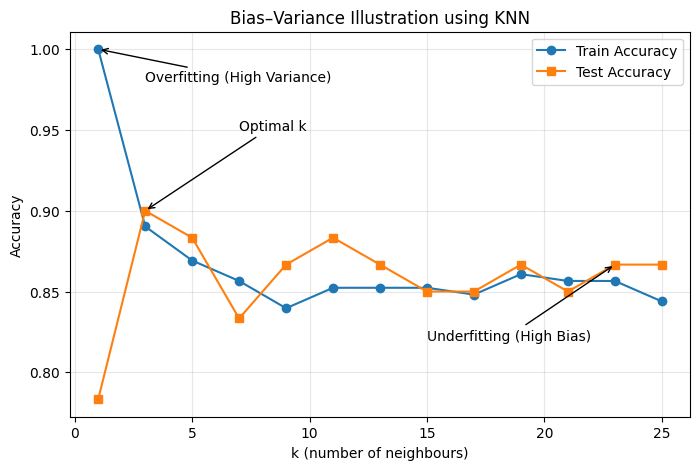

In [19]:
plt.figure(figsize=(8,5))
plt.plot(k_values, train_scores, marker="o", label="Train Accuracy")
plt.plot(k_values, test_scores, marker="s", label="Test Accuracy")

plt.xlabel("k (number of neighbours)")
plt.ylabel("Accuracy")
plt.title("Bias–Variance Illustration using KNN")

# Annotate high variance region
plt.annotate("Overfitting (High Variance)",
             xy=(1, train_scores[0]),
             xytext=(3, 0.98),
             arrowprops=dict(arrowstyle="->"))

# Annotate optimal region
best_k = 3
plt.annotate("Optimal k",
             xy=(best_k, test_scores[1]),
             xytext=(best_k+4, test_scores[1]+0.05),
             arrowprops=dict(arrowstyle="->"))

# Annotate high bias region
plt.annotate("Underfitting (High Bias)",
             xy=(23, test_scores[-2]),
             xytext=(15, 0.82),
             arrowprops=dict(arrowstyle="->"))

plt.grid(alpha=0.3)
plt.legend()
plt.show()
